In [10]:
import os
import numpy as np
from pandas import DataFrame
from pandas.io.parsers import read_csv
from datetime import datetime
%matplotlib inline 

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage import exposure
import theano

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Other Functions or Classes
# Function to load train/test csv files 
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

# Class to display list as HTML Table in Jupyter Notebook
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=30, c='blue')

In [4]:
FTRAIN = '/data/facial_keypoints_detection/training.csv'
FTEST = '/data/facial_keypoints_detection/test.csv'

# Load Test data
Test_X, _ = load(test=True)

# Load Train data
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

ImageId    1783
Image      1783
dtype: int64
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mou

100
Train, valid errors and computational time of last epcho: 0.0023, 0.0030, 0.0705
200
Train, valid errors and computational time of last epcho: 0.0014, 0.0025, 0.0802
300
Train, valid errors and computational time of last epcho: 0.0011, 0.0025, 0.0907
400
Train, valid errors and computational time of last epcho: 0.0010, 0.0026, 0.0977
500
Train, valid errors and computational time of last epcho: 0.0009, 0.0025, 0.1047
600
Train, valid errors and computational time of last epcho: 0.0009, 0.0026, 0.1209
700
Train, valid errors and computational time of last epcho: 0.0008, 0.0027, 0.1274
800
Train, valid errors and computational time of last epcho: 0.0008, 0.0028, 0.1391
900
Train, valid errors and computational time of last epcho: 0.0007, 0.0028, 0.1514
1000
Train, valid errors and computational time of last epcho: 0.0007, 0.0028, 0.1472


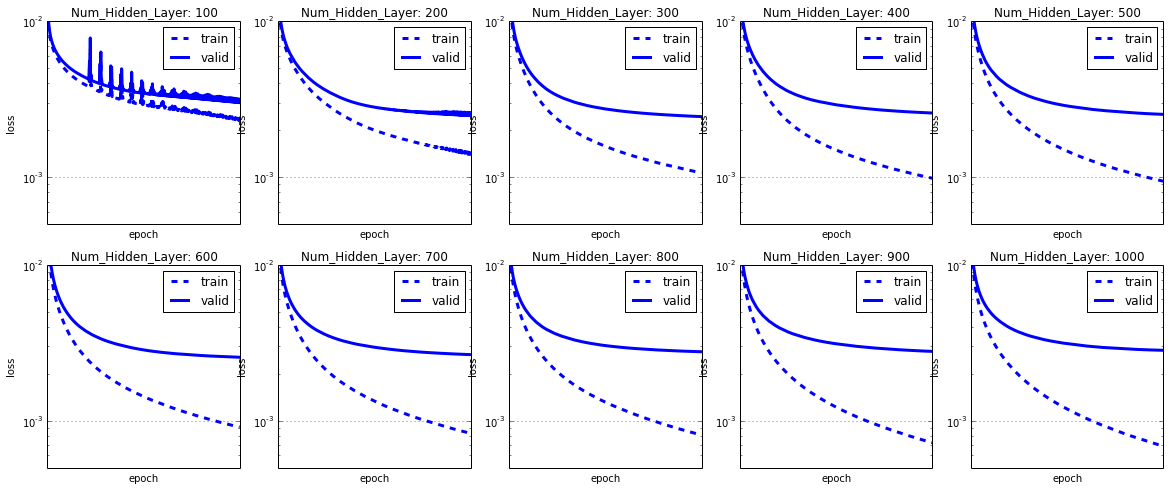

Num_hidden_layer,Train_loss,Validation_loss,Duration_time(s)
100,0.00234,0.00302,0.07048
200,0.00141,0.00252,0.08022
300,0.00107,0.00245,0.0907
400,0.00099,0.00259,0.09771
500,0.00094,0.00253,0.10468
600,0.00091,0.00256,0.12092
700,0.00083,0.00266,0.12741
800,0.00081,0.00277,0.13913
900,0.00072,0.00279,0.15141
1000,0.00069,0.00283,0.14717


In [19]:
# a list of hiddern unit number
hidden_num_units = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# Define a listtable to hold statsitical outcomes of NNs with various hiddern unit numbers 
performance_table_1 = ListTable()
performance_table_1.append(['Num_hidden_layer', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])

fig = plt.figure(figsize=(20,8))

for index,num in enumerate(hidden_num_units):
    net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                             ('hidden', layers.DenseLayer),
                             ('output', layers.DenseLayer),],
                     input_shape=(None, 9216),  # 96x96 input pixels per batch
                     #hidden_num_units=200,  # number of units in hidden layer
                     output_nonlinearity=None,  # output layer uses identity function
                     output_num_units=30,  # 30 target values
                     
                     update=nesterov_momentum, # optimization parameters
                     update_learning_rate=0.01,
                     update_momentum=0.9,
                     
                     regression=True,  # flag to indicate we're dealing with regression problem
                     max_epochs=1000,  # we want to train this many epochs
                     verbose=0,)
    net1.hidden_num_units = num
    net1.fit(X, y)
    
    train_loss = np.array([i["train_loss"] for i in net1.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
    print net1.hidden_num_units 
    print "Train, valid errors and computational time of last epcho: %0.4f, %0.4f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])
    performance_table_1.append([net1.hidden_num_units,
                                round(net1.train_history_[-1]["train_loss"],5),
                                round(net1.train_history_[-1]["valid_loss"],5),
                                round(net1.train_history_[-1]["dur"],5)] )
    
    subfig = fig.add_subplot(2, 5, index+1, xticks=[], yticks=[])
    plt.plot(train_loss, linewidth=3, color="blue", linestyle="dashed", label="train")
    plt.plot(valid_loss, linewidth=3, color="blue", linestyle="solid", label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(5*1e-4, 1e-2)
    plt.xlim(0,1000)
    plt.yscale("log")
    subfig.set_title('Num_Hidden_Layer: ' + str(num))

plt.show()
performance_table_1  

Train, valid errors and computational time of last epcho: 0.00094, 0.00244, 0.0926


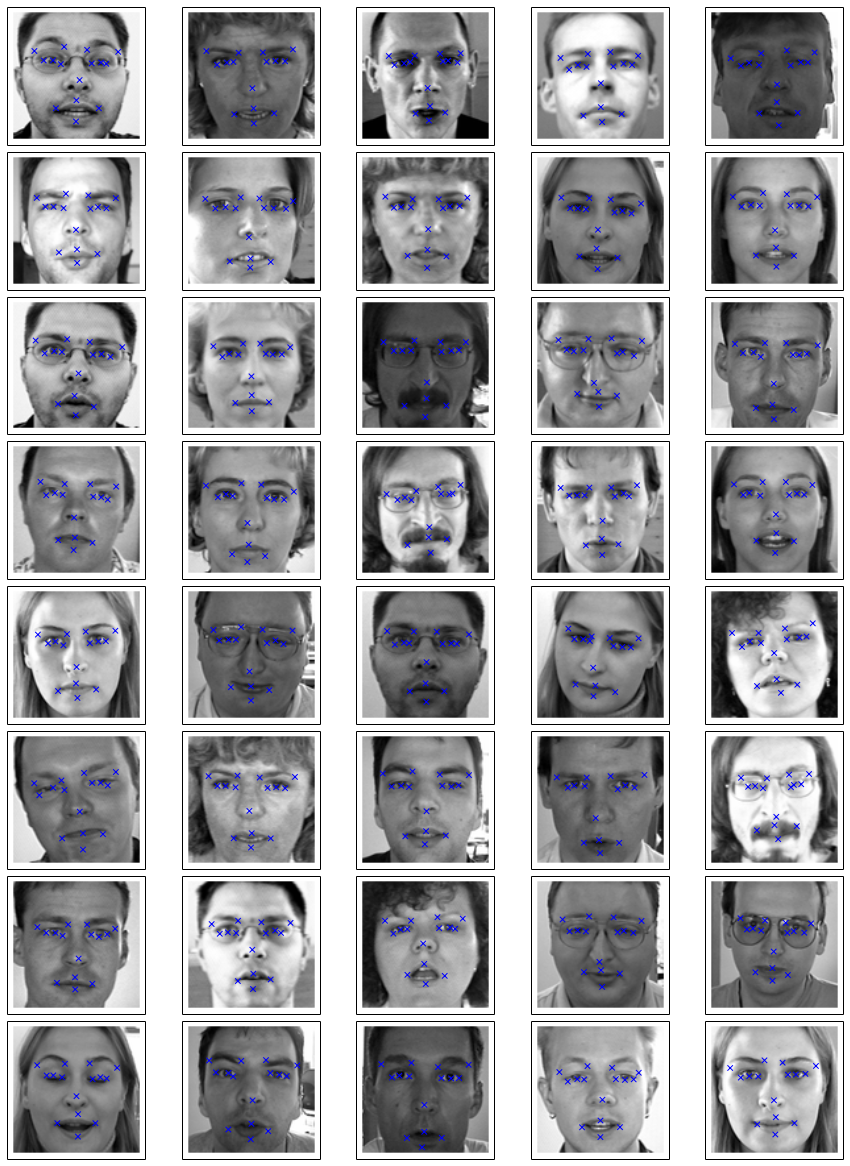

In [11]:
net1 = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=1000,  # we want to train this many epochs
                 verbose=0,)

net1.fit(X, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1.train_history_[-1]["train_loss"], net1.train_history_[-1]["valid_loss"], net1.train_history_[-1]["dur"])

Test_y_pred = net1.predict(Test_X)

fig = plt.figure(figsize=(12, 16))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(40):
    ax = fig.add_subplot(8, 5, i + 1, xticks=[], yticks=[])
    plot_sample(Test_X[i], Test_y_pred[i], ax)

plt.show()

In [33]:
print Test_X.shape

(1783, 9216)


In [7]:


X_stretch = np.empty_like(X)
X_eq = np.empty_like(X)
X_adapteq = np.empty_like(X)


for i in range(X.shape[0]):
    img = X[i,]
    p_lowbound, p_upperbound = np.percentile(img, (1, 99))
    X_stretch[i,] = exposure.rescale_intensity(img, in_range=(p_lowbound,p_upperbound ))
    
for i in range(X.shape[0]):
    img = X[i,]
    X_eq[i,] =  exposure.equalize_hist(img,nbins=255)

for i in range(X.shape[0]):
    img = X[i,].reshape(96,96)
    X_adapteq[i,] =  exposure.equalize_adapthist(img, clip_limit=0.03).flatten()
    

In [76]:
print X_adapteq.shape
print X_adapteq[0]

(2140, 9216)
[ 65535.  65535.  62302. ...,  17998.  32767.  36921.]


In [74]:
net1_stretch = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=1000,  # we want to train this many epochs
                 verbose=0,)

net1_stretch.fit(X_stretch, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_stretch.train_history_[-1]["train_loss"], net1_stretch.train_history_[-1]["valid_loss"], net1_stretch.train_history_[-1]["dur"])


net1_eq = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=1000,  # we want to train this many epochs
                 verbose=0,)
net1_eq.fit(X_eq, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_eq.train_history_[-1]["train_loss"], net1_eq.train_history_[-1]["valid_loss"], net1_eq.train_history_[-1]["dur"])

'''
net1_adapteq = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=1000,  # we want to train this many epochs
                 verbose=0,)
net1_adapteq.fit(X_adapteq, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_adapteq.train_history_[-1]["train_loss"], net1_adapteq.train_history_[-1]["valid_loss"], net1_adapteq.train_history_[-1]["dur"])
'''


Train, valid errors and computational time of last epcho: 0.00091, 0.00268, 0.0929
Train, valid errors and computational time of last epcho: 0.00099, 0.00197, 0.0926
Train, valid errors and computational time of last epcho: nan, nan, 0.0926


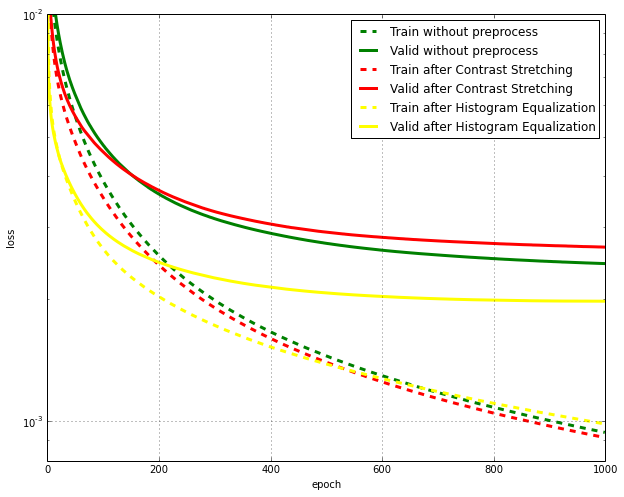

Preprocess,Train_loss,Validation_loss,Duration_time(s)
Without Preprocessing,0.00094,0.00244,0.09263
Contrast stretching,0.00091,0.00268,0.09288
Histogram equalization,0.00099,0.00197,0.09257


In [78]:
# Extract training and validation loss for various models
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net1_str_train_loss = np.array([i["train_loss"] for i in net1_stretch.train_history_])
net1_str_valid_loss = np.array([i["valid_loss"] for i in net1_stretch.train_history_])
net1_eq_train_loss = np.array([i["train_loss"] for i in net1_eq.train_history_])
net1_eq_valid_loss = np.array([i["valid_loss"] for i in net1_eq.train_history_])
net1_adapteq_train_loss = np.array([i["train_loss"] for i in net1_adapteq.train_history_])
net1_adapteq_valid_loss = np.array([i["valid_loss"] for i in net1_adapteq.train_history_])

# Plot for performance comparision between differnt preprocesses
plt.figure(figsize=(10, 8))
plt.plot(net1_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Train without preprocess")
plt.plot(net1_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Valid without preprocess")
plt.plot(net1_str_train_loss, linewidth=3,  color="red", linestyle="dashed", label="Train after Contrast Stretching")
plt.plot(net1_str_valid_loss, linewidth=3,  color="red", linestyle="solid", label="Valid after Contrast Stretching")
plt.plot(net1_eq_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Train after Histogram Equalization")
plt.plot(net1_eq_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Valid after Histogram Equalization")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(8*1e-4, 1e-2)
plt.yscale("log")

plt.show()

# Define a listtable to hold statsitical outcomes of NNs with various preprocessing steps 
performance_table_2 = ListTable()
performance_table_2.append(['Preprocess', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])
performance_table_2.append(['Without Preprocessing',
                            round(net1.train_history_[-1]["train_loss"],5),
                            round(net1.train_history_[-1]["valid_loss"],5),
                            round(net1.train_history_[-1]["dur"],5)] )
performance_table_2.append(['Contrast stretching',
                            round(net1_stretch.train_history_[-1]["train_loss"],5),
                            round(net1_stretch.train_history_[-1]["valid_loss"],5),
                            round(net1_stretch.train_history_[-1]["dur"],5)] )    
performance_table_2.append(['Histogram equalization',
                            round(net1_eq.train_history_[-1]["train_loss"],5),
                            round(net1_eq.train_history_[-1]["valid_loss"],5),
                            round(net1_eq.train_history_[-1]["dur"],5)] )   
performance_table_2  




In [66]:
from scipy import fftpack

def idct2(xIn2Dim):
    return fftpack.idct(fftpack.idct(xIn2Dim, norm = 'ortho').T, norm = 'ortho')

def dct2(xIn, xDim = 96, yDim = 96):
    #dctback = fftpack.idct(dct)

    return fftpack.dct(fftpack.dct(xIn.reshape(xDim,yDim), norm = 'ortho').T, norm = 'ortho')

def primHPF(xIn2Dim, level = 5):
    shape0 = xIn2Dim.shape[0]
    shape1 = xIn2Dim.shape[1]
    
    for i in range(shape0 - level, shape0):
        for j in range(shape1 - level, shape1):
            xIn2Dim[i,j] = 0
    return xIn2Dim

hpfX = np.empty_like(X)
for i in range(X.shape[0]):
    hpfX[i] = idct2(primHPF(dct2(X[i]))).reshape(96 * 96)
    
net1_hpf = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                         ('hidden', layers.DenseLayer),
                         ('output', layers.DenseLayer),],
                 input_shape=(None, 9216),  # 96x96 input pixels per batch
                 hidden_num_units=500,  # number of units in hidden layer
                 output_nonlinearity=None,  # output layer uses identity function
                 output_num_units=30,  # 30 target values
                 
                 update=nesterov_momentum, # optimization parameters
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 regression=True,  # flag to indicate we're dealing with regression problem
                 max_epochs=1000,  # we want to train this many epochs
                 verbose=0,)

net1_hpf.fit(hpfX, y)
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_hpf.train_history_[-1]["train_loss"], net1_hpf.train_history_[-1]["valid_loss"], net1_hpf.train_history_[-1]["dur"])


Train, valid errors and computational time of last epcho: 0.00091, 0.00259, 0.0924


In [68]:
from nolearn.lasagne import BatchIterator

# randomly flip half of the images in each batch
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        for i in range(0, np.int64(bs/2)):
            X_trans = Xb[indices[i]].reshape(96, 96)
            X_trans = X_trans[:, ::-1]
            Xb[indices[i]] = X_trans.reshape(1, 9216)

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb


In [69]:

net1_augmentation = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                                      ('hidden', layers.DenseLayer),
                                      ('output', layers.DenseLayer),],
                              # layer parameters:
                              input_shape=(None, 9216),  # 96x96 input pixels per batch
                              hidden_num_units=500,  # number of units in hidden layer
                              output_nonlinearity=None,  # output layer uses identity function
                              output_num_units=30,  # 30 target values
                              
                              # optimization parameters:
                              update=nesterov_momentum,
                              update_learning_rate=0.01,
                              update_momentum=0.9,
                 
                              regression=True,  # flag to indicate we're dealing with regression problem
                              batch_iterator_train=FlipBatchIterator(batch_size=128),
                              max_epochs=1000,  # we want to train this many epocho
                              verbose=1,)

net1_augmentation.fit(X, y)

  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.14714       0.02153      6.83419  0.09s
      2       0.01870       0.01828      1.02320  0.09s
      3       0.01623       0.01652      0.98277  0.09s
      4       0.01489       0.01554      0.95816  0.09s
      5       0.01408       0.01489      0.94529  0.09s
      6       0.01354       0.01434      0.94401  0.09s
      7       0.01299       0.01384      0.93847  0.09s
      8       0.01256       0.01340      0.93769  0.09s
      9       0.01214       0.01297      0.93555  0.09s
     10       0.01180       0.01265      0.93299  0.09s
     11       0.01141       0.01231      0.92675  0.09s
     12       0.01121       0.01202      0.93284  0.09s
     13       0.0

NeuralNet(X_tensor_type=<function matrix at 0x7f15c4c6ff50>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f15bc00d390>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f15a0755150>,
     custom_score=None, eval_size=0.2, hidden_num_units=500,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x7f15bc918938>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x7f15a0a69cb0>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x7f15bc9240c8>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbos

In [79]:
net1_eq_augmentation = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                                      ('hidden', layers.DenseLayer),
                                      ('output', layers.DenseLayer),],
                              # layer parameters:
                              input_shape=(None, 9216),  # 96x96 input pixels per batch
                              hidden_num_units=500,  # number of units in hidden layer
                              output_nonlinearity=None,  # output layer uses identity function
                              output_num_units=30,  # 30 target values
                              
                              # optimization parameters:
                              update=nesterov_momentum,
                              update_learning_rate=0.01,
                              update_momentum=0.9,
                 
                              regression=True,  # flag to indicate we're dealing with regression problem
                              batch_iterator_train=FlipBatchIterator(batch_size=128),
                              max_epochs=1000,  # we want to train this many epocho
                              verbose=1,)

net1_eq_augmentation.fit(X_eq, y)

  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.27913       0.01420     19.65322  0.09s
      2       0.01216       0.00955      1.27262  0.10s
      3       0.00920       0.00791      1.16331  0.09s
      4       0.00798       0.00714      1.11719  0.10s
      5       0.00731       0.00663      1.10307  0.10s
      6       0.00690       0.00634      1.08733  0.09s
      7       0.00651       0.00606      1.07434  0.10s
      8       0.00628       0.00586      1.07155  0.10s
      9       0.00605       0.00569      1.06466  0.09s
     10       0.00587       0.00552      1.06320  0.10s
     11       0.00574       0.00540      1.06203  0.09s
     12       0.00562       0.00531      1.05934  0.09s
     13       0.0

NeuralNet(X_tensor_type=<function matrix at 0x7f15c4c6ff50>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f15bc00d390>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f159bce7c90>,
     custom_score=None, eval_size=0.2, hidden_num_units=500,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x7f15bc918938>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x7f15b6bcc3f8>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x7f15bc9240c8>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbos

Train, valid errors and computational time of last epcho: 0.00137, 0.00225, 0.0938
Train, valid errors and computational time of last epcho: 0.00137, 0.00191, 0.0938


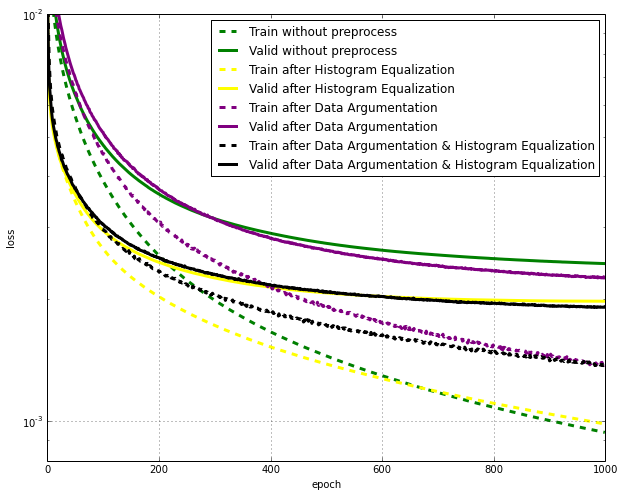

In [81]:
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_augmentation.train_history_[-1]["train_loss"], net1_augmentation.train_history_[-1]["valid_loss"], net1_augmentation.train_history_[-1]["dur"])
print "Train, valid errors and computational time of last epcho: %0.5f, %0.5f, %0.4f" %(net1_eq_augmentation.train_history_[-1]["train_loss"], net1_eq_augmentation.train_history_[-1]["valid_loss"], net1_augmentation.train_history_[-1]["dur"])


# Extract training and validation loss for various models
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net1_eq_train_loss = np.array([i["train_loss"] for i in net1_eq.train_history_])
net1_eq_valid_loss = np.array([i["valid_loss"] for i in net1_eq.train_history_])
net1_augmentation_train_loss = np.array([i["train_loss"] for i in net1_augmentation.train_history_])
net1_augmentation_valid_loss = np.array([i["valid_loss"] for i in net1_augmentation.train_history_])
net1_eq_augmentation_train_loss = np.array([i["train_loss"] for i in net1_eq_augmentation.train_history_])
net1_eq_augmentation_valid_loss = np.array([i["valid_loss"] for i in net1_eq_augmentation.train_history_])

# Plot for performance comparision between differnt preprocesses
plt.figure(figsize=(10, 8))
plt.plot(net1_train_loss, linewidth=3,  color="green", linestyle="dashed", label="Train without preprocess")
plt.plot(net1_valid_loss, linewidth=3,  color="green", linestyle="solid", label="Valid without preprocess")
plt.plot(net1_eq_train_loss, linewidth=3,  color="yellow", linestyle="dashed", label="Train after Histogram Equalization")
plt.plot(net1_eq_valid_loss, linewidth=3,  color="yellow", linestyle="solid", label="Valid after Histogram Equalization")
plt.plot(net1_augmentation_train_loss, linewidth=3,  color="purple", linestyle="dashed", label="Train after Data Argumentation")
plt.plot(net1_augmentation_valid_loss, linewidth=3,  color="purple", linestyle="solid", label="Valid after Data Argumentation")
plt.plot(net1_eq_augmentation_train_loss, linewidth=3,  color="black", linestyle="dashed", label="Train after Data Argumentation & Histogram Equalization")
plt.plot(net1_eq_augmentation_valid_loss, linewidth=3,  color="black", linestyle="solid", label="Valid after Data Argumentation & Histogram Equalization")


plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(8*1e-4, 1e-2)
plt.yscale("log")

plt.show()



Dropout Rate is: 0.00
Train, valid errors and computational time of last epcho: 0.0010, 0.0027, 0.0922
Dropout Rate is: 0.05
Train, valid errors and computational time of last epcho: 0.0013, 0.0023, 0.0935
Dropout Rate is: 0.10
Train, valid errors and computational time of last epcho: 0.0014, 0.0022, 0.0942
Dropout Rate is: 0.15
Train, valid errors and computational time of last epcho: 0.0015, 0.0023, 0.0904
Dropout Rate is: 0.20
Train, valid errors and computational time of last epcho: 0.0016, 0.0022, 0.0947
Dropout Rate is: 0.25
Train, valid errors and computational time of last epcho: 0.0018, 0.0022, 0.0942
Dropout Rate is: 0.30
Train, valid errors and computational time of last epcho: 0.0019, 0.0022, 0.0903
Dropout Rate is: 0.35
Train, valid errors and computational time of last epcho: 0.0020, 0.0022, 0.0940
Dropout Rate is: 0.40
Train, valid errors and computational time of last epcho: 0.0020, 0.0022, 0.0937
Dropout Rate is: 0.45
Train, valid errors and computational time of last 

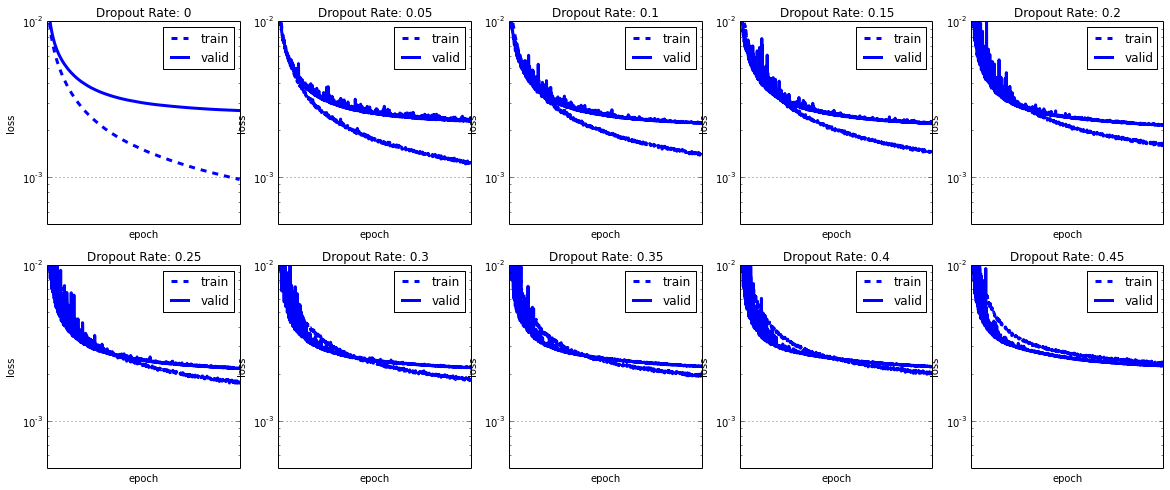

Dropout_rate,Train_loss,Validation_loss,Duration_time(s)
0,0.00097,0.00268,0.09222
0.05,0.00127,0.00229,0.09355
0.1,0.0014,0.00224,0.09424
0.15,0.00146,0.00225,0.0904
0.2,0.0016,0.00217,0.0947
0.25,0.00175,0.00217,0.09424
0.3,0.00186,0.00219,0.09033
0.35,0.00196,0.00223,0.09403
0.4,0.00201,0.00223,0.09369
0.45,0.00232,0.00227,0.09407


In [9]:
# a list of dropout rate
dropout_rate = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

# Define a listtable to hold statsitical outcomes of NNs with various hiddern unit numbers 
performance_table_3 = ListTable()
performance_table_3.append(['Dropout_rate', 'Train_loss', 'Validation_loss', 'Duration_time(s)'])

fig = plt.figure(figsize=(20,8))

for index,num in enumerate(dropout_rate):
    net1_dropout = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                                     ('hidden', layers.DenseLayer),
                                     ('dropout1', layers.DropoutLayer),
                                     ('output', layers.DenseLayer),],
                             
                             input_shape=(None, 9216),  # 96x96 input pixels per batch
                             hidden_num_units=500,  # number of units in hidden layer
                             output_nonlinearity=None,  # output layer uses identity function
                             output_num_units=30,  # 30 target values
                             
                             update=nesterov_momentum, # optimization parameters
                             update_learning_rate=0.01,
                             update_momentum=0.9,
                             
                             regression=True,  # flag to indicate we're dealing with regression problem
                             max_epochs=1000,  # we want to train this many epochs
                             verbose=0,)
    net1_dropout.dropout1_p = num
    net1_dropout.fit(X, y)
    
    train_loss = np.array([i["train_loss"] for i in net1_dropout.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net1_dropout.train_history_])
    print "Dropout Rate is: %.2f" %net1_dropout.dropout1_p 
    print "Train, valid errors and computational time of last epcho: %0.4f, %0.4f, %0.4f" %(net1_dropout.train_history_[-1]["train_loss"], net1_dropout.train_history_[-1]["valid_loss"], net1_dropout.train_history_[-1]["dur"])
    performance_table_3.append([net1_dropout.dropout1_p,
                                round(net1_dropout.train_history_[-1]["train_loss"],5),
                                round(net1_dropout.train_history_[-1]["valid_loss"],5),
                                round(net1_dropout.train_history_[-1]["dur"],5)] )
    
    subfig = fig.add_subplot(2, 5, index+1, xticks=[], yticks=[])
    plt.plot(train_loss, linewidth=3, color="blue", linestyle="dashed", label="train")
    plt.plot(valid_loss, linewidth=3, color="blue", linestyle="solid", label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(5*1e-4, 1e-2)
    plt.xlim(0,1000)
    plt.yscale("log")
    subfig.set_title('Dropout Rate: ' + str(num))

plt.show()
performance_table_3  

In [6]:
net1_dropout = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                                 ('hidden', layers.DenseLayer),
                                 ('dropout1', layers.DropoutLayer),
                                 ('output', layers.DenseLayer),],
                         
                         input_shape=(None, 9216),  # 96x96 input pixels per batch
                         hidden_num_units=500,  # number of units in hidden layer
                         output_nonlinearity=None,  # output layer uses identity function
                         output_num_units=30,  # 30 target values
                         dropout1_p=0.1,
                 
                         update=nesterov_momentum, # optimization parameters
                         update_learning_rate=0.01,
                         update_momentum=0.9,
                         
                         regression=True,  # flag to indicate we're dealing with regression problem
                         max_epochs=1000,  # we want to train this many epochs
                         verbose=1,)


net1_dropout.fit(X, y)



  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 500)         	produces     500 outputs
  dropout1          	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.17230       0.02210      7.79776  0.10s
      2       0.02440       0.01737      1.40484  0.10s
      3       0.02049       0.01574      1.30183  0.09s
      4       0.01819       0.01493      1.21815  0.09s
      5       0.01684       0.01338      1.25829  0.09s
      6       0.01559       0.01298      1.20087  0.09s
      7       0.01463       0.01225      1.19441  0.10s
      8       0.01393       0.01196      1.16444  0.10s
      9       0.01331       0.01128      1.17905  0.10s
     10       0.01275       0.01107      1.15188  0.10s
     11       0.01225       0.01088      1.12598  0.10s
     1

NeuralNet(X_tensor_type=<function matrix at 0x7f1714481ed8>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f170c56eb50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f170c56e6d0>,
     custom_score=None, dropout1_p=0.1, eval_size=0.2,
     hidden_num_units=500, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x7f170d4c3de8>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x7f170c4cd368>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x7f170d4c7578>,
     u

In [16]:
import theano.tensor as T
#from lasagne.nonlinearities import softmax
#from lasagne.layers import InputLayer, DenseLayer
from lasagne import regularization
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params

net1_l2norm = NeuralNet(layers=[('input', layers.InputLayer), # three layers
                                ('hidden', layers.DenseLayer),
                                ('output', layers.DenseLayer),],
                         
                        input_shape=(None, 9216),  # 96x96 input pixels per batch
                        hidden_num_units=500,  # number of units in hidden layer
                        output_nonlinearity=None,  # output layer uses identity function
                        output_num_units=30,  # 30 target values
                          
                        loss = lasagne.objectives.mse + 0.0001*lasagne.regularization.l2(output),
                        
                        update=nesterov_momentum, # optimization parameters
                        update_learning_rate=0.01,
                        update_momentum=0.9,
                         
                        regression=True,  # flag to indicate we're dealing with regression problem
                        max_epochs=1000,  # we want to train this many epochs
                        verbose=1,)


net1_l2norm.fit(X, y)


ImportError: cannot import name regularize_layer_params_weighted